In [10]:
pip install scikit-fuzzy


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: C:\Users\larac\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [11]:
pip install paho-mqtt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: C:\Users\larac\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


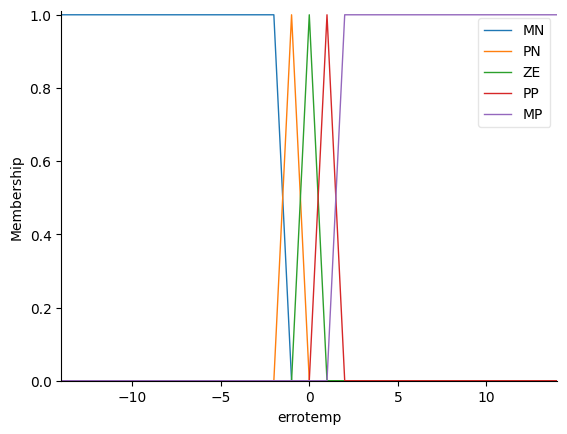

In [12]:
import numpy as np
import skfuzzy as fuzz
import paho.mqtt.client as mqtt
from skfuzzy import control as ctrl
import time

# New Antecedent/Consequent objects hold universe variables and membership
# functions
errotemp = ctrl.Antecedent(np.arange(-14, 14.1, 0.1), 'errotemp')
varerrotemp =ctrl.Antecedent(np.arange(-2, 2.1, 0.1), 'varerrotemp')
aquecedor =ctrl.Consequent(np.arange(0, 101, 1), 'aquecedor')


# Custom membership functions can be built interactively with a familiar,
# Pythonic API
errotemp['MN'] = fuzz.trapmf(errotemp.universe, [-14, -14, -2,-1])
errotemp['PN'] = fuzz.trimf(errotemp.universe, [-2,-1,0])
errotemp['ZE'] = fuzz.trimf(errotemp.universe, [-1, 0, 1])
errotemp['PP'] = fuzz.trimf(errotemp.universe, [0, 1, 2])
errotemp['MP'] = fuzz.trapmf(errotemp.universe,[1, 2, 14,14])
# You can see how these look with .view()
errotemp.view()

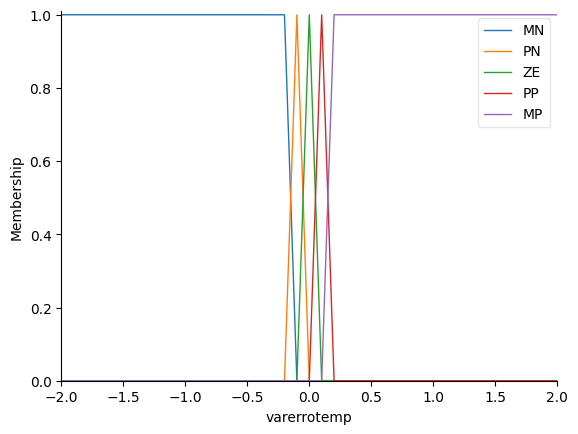

In [13]:
varerrotemp['MN'] = fuzz.trapmf(varerrotemp.universe, [-2, -2, -0.2,-0.1])
varerrotemp['PN'] = fuzz.trimf(varerrotemp.universe, [-0.2,-0.1,0])
varerrotemp['ZE'] = fuzz.trimf(varerrotemp.universe, [-0.1, 0, 0.1])
varerrotemp['PP'] = fuzz.trimf(varerrotemp.universe, [0, 0.1, 0.2])
varerrotemp['MP'] = fuzz.trapmf(varerrotemp.universe,[0.1, 0.2, 2.1, 2.1])
# You can see how these look with .view()
varerrotemp.view()

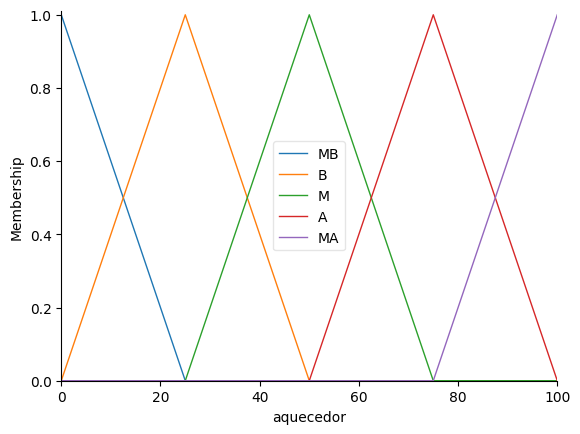

In [14]:
# 2. Redefinição das Funções de Pertinência (CENTRALIZADAS EM 50%)
aquecedor['MB'] = fuzz.trimf(aquecedor.universe, [0, 0, 25])
aquecedor['B'] = fuzz.trimf(aquecedor.universe, [0, 25, 50])
aquecedor['M'] = fuzz.trimf(aquecedor.universe, [25, 50, 75]) # Ponto de Estabilidade
aquecedor['A'] = fuzz.trimf(aquecedor.universe, [50, 75, 100])
aquecedor['MA'] = fuzz.trimf(aquecedor.universe, [75, 100, 100])
aquecedor.view()


In [15]:
# CÉLULA 7: NOVA BASE DE REGRAS (CONTROLADOR CRAC - RESFRIAMENTO)

# O CRAC precisa de MÁXIMA POTÊNCIA (MA) quando o ERRO for MN (Temperatura Muito ACIMA do SP)

# --- LINHA ERRO 'MN' (Temperatura Muito ACIMA do SP) ---
regra1 = ctrl.Rule(errotemp['MN'] & varerrotemp['MN'], aquecedor['MA'])
regra2 = ctrl.Rule(errotemp['MN'] & varerrotemp['PN'], aquecedor['MA'])
regra3 = ctrl.Rule(errotemp['MN'] & varerrotemp['ZE'], aquecedor['MA'])
regra4 = ctrl.Rule(errotemp['MN'] & varerrotemp['PP'], aquecedor['A'])
regra5 = ctrl.Rule(errotemp['MN'] & varerrotemp['MP'], aquecedor['M'])

# --- LINHA ERRO 'PN' (Temperatura Pouco ACIMA do SP) ---
regra6 = ctrl.Rule(errotemp['PN'] & varerrotemp['MN'], aquecedor['MA'])
regra7 = ctrl.Rule(errotemp['PN'] & varerrotemp['PN'], aquecedor['A'])
regra8 = ctrl.Rule(errotemp['PN'] & varerrotemp['ZE'], aquecedor['A'])
regra9 = ctrl.Rule(errotemp['PN'] & varerrotemp['PP'], aquecedor['M'])
regra10 = ctrl.Rule(errotemp['PN'] & varerrotemp['MP'], aquecedor['B'])

# --- LINHA ERRO 'ZE' (Temperatura em Torno do SP) ---
regra11 = ctrl.Rule(errotemp['ZE'] & varerrotemp['MN'], aquecedor['B'])
regra12 = ctrl.Rule(errotemp['ZE'] & varerrotemp['PN'], aquecedor['A'])
regra13 = ctrl.Rule(errotemp['ZE'] & varerrotemp['ZE'], aquecedor['M']) # Estabilidade
regra14 = ctrl.Rule(errotemp['ZE'] & varerrotemp['PP'], aquecedor['B'])
regra15 = ctrl.Rule(errotemp['ZE'] & varerrotemp['MP'], aquecedor['MB'])

# --- LINHA ERRO 'PP' (Temperatura Pouco ABAIXO do SP) ---
regra16 = ctrl.Rule(errotemp['PP'] & varerrotemp['MN'], aquecedor['MB'])
regra17 = ctrl.Rule(errotemp['PP'] & varerrotemp['PN'], aquecedor['B'])
regra18 = ctrl.Rule(errotemp['PP'] & varerrotemp['ZE'], aquecedor['B'])
regra19 = ctrl.Rule(errotemp['PP'] & varerrotemp['PP'], aquecedor['M'])
regra20 = ctrl.Rule(errotemp['PP'] & varerrotemp['MP'], aquecedor['A'])

# --- LINHA ERRO 'MP' (Temperatura Muito ABAIXO do SP) ---
regra21 = ctrl.Rule(errotemp['MP'] & varerrotemp['MN'], aquecedor['M'])
regra22 = ctrl.Rule(errotemp['MP'] & varerrotemp['PN'], aquecedor['B'])
regra23 = ctrl.Rule(errotemp['MP'] & varerrotemp['ZE'], aquecedor['MB'])
regra24 = ctrl.Rule(errotemp['MP'] & varerrotemp['PP'], aquecedor['MB'])
regra25 = ctrl.Rule(errotemp['MP'] & varerrotemp['MP'], aquecedor['MB'])

In [16]:
aquecedor_ctrl = ctrl.ControlSystem([regra1, regra2, regra3,regra4,regra5,regra6, regra7, regra8,regra9,regra10,regra11, regra12, regra13,regra14,regra15,regra16, regra17, regra18,regra19,regra20,regra21, regra22, regra23,regra24,regra25])
potencia = ctrl.ControlSystemSimulation(aquecedor_ctrl)

In [17]:
import json

sp = 18
tempatual = 28
print(tempatual)
erroatual = 10

# Configuração do cliente MQTT
mqttBroker = "broker.hivemq.com"
client = mqtt.Client()
client.connect(mqttBroker, 1883, 60)

def publish_data(temp, crac, erro):
    """Publica os dados no tópico MQTT."""
    data_stream = {
        "t": time.time(),
        "temp": temp,
        "crac": crac,
        "erro": erro
    }
    client.publish("Projeto_C213/stream", json.dumps(data_stream))

    if abs(erro) > 5:
        alert_msg = {"msg": "Erro elevado detectado!", "tipo": "alert"}
        client.publish("Projeto_C213/alert", json.dumps(alert_msg))

while True:
    erroanterior = erroatual
    erroatual = tempatual - sp
    varerroTemp = erroatual - erroanterior
    potencia.input['errotemp'] = erroatual
    potencia.input['varerrotemp'] = varerroTemp
    potencia.compute()

    crac = max(0, min(100, 50 - erroatual * 2))  # Exemplo de cálculo do CRAC
    publish_data(tempatual, crac, erroatual)

    i = 0
    while i < 10:
        tempatual = tempatual * 0.9954 + potencia.output['aquecedor'] * 0.001963
        time.sleep(0.1)
        i += 1

    print(tempatual)
    client.publish("Aquecedor/Temperatura", tempatual)
    client.publish("Aquecedor/erro", erroatual)

28


C:\Users\larac\AppData\Local\Temp\ipykernel_9184\3563470159.py:10: DeprecationWarning: Callback API version 1 is deprecated, update to latest version
  client = mqtt.Client()


26.89857553218548
26.647972389901327
26.647972389901327
26.408661271541277
26.408661271541277
26.180133365431455
26.180133365431455
25.96190278664002
25.96190278664002
25.753505543912222
25.753505543912222
25.55449855315473
25.55449855315473
25.35732272539275
25.35732272539275
25.15646096385988
25.15646096385988
24.984356435778057
24.984356435778057
24.66811175151525
24.66811175151525
24.518011939491053
24.518011939491053
24.13470178366459
24.13470178366459
24.00863709771033
24.00863709771033
23.551460789798547
23.551460789798547
23.45167658539062
23.45167658539062
22.875653037589668
22.875653037589668
22.806320316098034
22.806320316098034
22.238042207470404
22.238042207470404
22.197439839007657
22.197439839007657
21.595360108346295
21.595360108346295
21.58371660118415
21.58371660118415
20.87476371046426
20.87476371046426
20.8955898351285
20.8955898351285
20.120037782037638
20.120037782037638
20.174871394246747
20.174871394246747
19.44856049218836
19.44856049218836
19.24961801621109
19

KeyboardInterrupt: 